*Note: all those exercises should be done using python with pyccel openmp*

## Exercise 1 Hello World

1. Write an OpenMP program displaying the number of threads used for the execution and the rank of each of the threads.
3. Test the programs obtained with different numbers of threads for the parallel program.

**Output Example**
```shell
>> Python hello.py
Hello from the rank 2 thread
Hello from the rank 0 thread
Hello from the rank 3 thread
Hello from the rank 1 thread
Hello from the rank 4 thread
Parallel execution of hello_world with 4 threads
```
*Note that the output order maybe different*

In [1]:
%%file hello.py
if __name__ =="__main__":
    from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
    omp_set_num_threads(4)
    #$ omp parallel
    rank = omp_get_thread_num(), omp_get_num_threads()
    print("Hello from the rank", rank[0],"threads", "\n")
    #$ omp end parallel
    print("Parallel execution of hello_world with ",rank[1]," threads")

Overwriting hello.py


In [2]:
!pyccel --language=c hello.py --openmp
#export OMP_NUM_THREADS=0
!./hello

Hello from the rank 0 threads 

Hello from the rank 3 threads 

Hello from the rank 1 threads 

Hello from the rank 2 threads 

Parallel execution of hello_world with  4  threads


In [3]:
import numpy as np

## Exercise 2 Matrix product

Considering the following code for matrix product:

1. Using pyccel, epyccelize the `matrix_prod` function, and time the execution of epyccelized function.
2. Insert the appropriate OpenMP directives and analyse the code performance.
3. Test the loop iteration repartition modes (`STATIC`, `DYNAMIC`, `GUIDED`) and vary the chunk sizes.
**Example output**

```bash
   Value of M and N           : 20 20 
    Temps elapsed              : 0.0009012222290039062 
    Temps CPU                  : 0.0 
    Partiel results            : 2790.0 2690.0 ... -3610.0 -4350.0 

 Execution of Matrix production in parallele with                     8 threads
```

In [4]:
import pyccel
from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads

In [5]:
def matrix_prod(A:'float[:,:]', B:'float[:,:]', C:'float[:,:]', N:'int', M:'int'):

    #$ omp parallel
    print("oui, c'est bon")
    #$ omp for collapse(2)reduction (+:A) 
    for i in range( M ):
        for j in range( N ):
            A[ i, j ] = (i + 1) + (j + 1)

    #$ omp for collapse(2)reduction (+:B) 
    for i in range( N ):
        for j in range( M ):
            B[ i, j ] = (i + 1) - (j + 1)

    #$ omp for collapse(2)
    for i in range( M ):
        for j in range( M ):
            C[ i, j ] = 0
    
    # Matrix Production

    #$ omp for collapse(3) reduction (*:C) reduction (+:C) 
    for i in range( M ):
        for j in range( M ):
            for k in range( N ):
                C[ i, j ] += A[ i, k ] * B[ k, j ]
    
    #$ omp end parallel
    return 0

#     print("Execution of Matrix production in parallele with",nb_threads, "threads")
if __name__ == "__main__":
    import numpy as np
    import time
    import math
    from pyccel.epyccel import epyccel
    threads=8
    from pyccel.stdlib.internal.openmp import  omp_set_num_threads
    omp_set_num_threads(threads)

    M = 20
    N = 20


    # Declare Matrices
    A = np.empty((M, N), dtype=np.double)
    B = np.empty((N, M), dtype=np.double)
    C = np.empty((M, M), dtype=np.double)

#   #run and time the matrix_prod function  
    #reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    product = epyccel(matrix_prod, language="c", accelerators= ' openmp ')
    import timeit
    # start CPU timing
    tcpu_0 = time.process_time() 
    # start whole timing
    t1 = time.time()
    
    product(A,B,C,N,M)
    # CPU time 
    tcpu = time.process_time() - tcpu_0  
    # whole time
    temps_execution = time.time() - t1
    
    print("Value of M and N   :", M," ",N,'\n',
        "Temps elapsed      :", temps_execution,  '\n',
        "Partiel results   :", C[0],    '\n',
        "CPU time       :", tcpu,        '\n'
        "Execution of Matrix production in parallele with ",threads,"threads"
    )

Value of M and N   : 20   20 
 Temps elapsed      : 3.266334533691406e-05 
 Partiel results   : [ 2850.  2620.  2390.  2160.  1930.  1700.  1470.  1240.  1010.   780.
   550.   320.    90.  -140.  -370.  -600.  -830. -1060. -1290. -1520.] 
 CPU time       : 3.617899999985852e-05 
Execution of Matrix production in parallele with  8 threads


### Measure the code performance and plot the speedup curves obtained.

In [6]:
threads = 8
temps_execution = []
for i in range(0,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        execute = epyccel(matrix_prod, language="c", accelerators= ' openmp ')
        import timeit
        t1 = time.time()

        execute(A,B,C,N,M)
        temps_execution.append(time.time()- t1)
print(temps_execution) 



[2.2411346435546875e-05, 3.314018249511719e-05, 5.435943603515625e-05, 3.647804260253906e-05, 3.123283386230469e-05, 3.361701965332031e-05, 2.4557113647460938e-05, 2.6702880859375e-05]


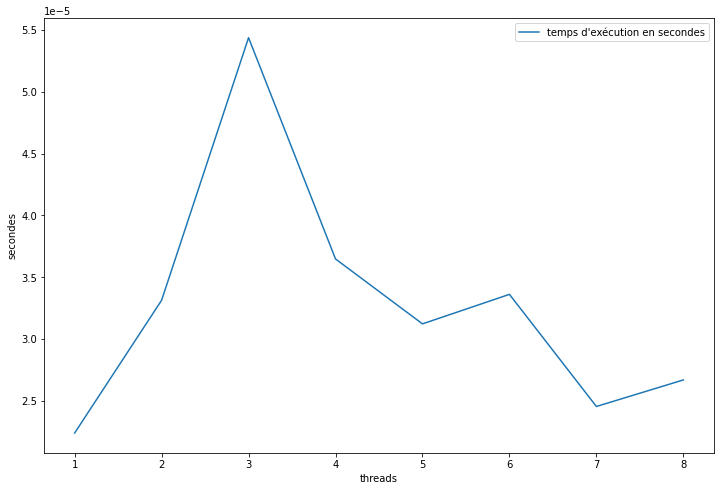

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()

## Exercise 3 Jacobi method

Considering the following code for a general linear system solver:

$$ A \times x = b $$

using the Jacobi iterative method.
In this exercice, you must solve the system in parallel
   
**Example Output**
    
```bash
System size    : 20 
 Iterations     : 21 
 Stand          : 2.9100049961372497e-08 
 Elapsed Time   : 7.447303771972656 
 CPU time       : 0.921875 
```

In [8]:
def jacobi(a:'float[:,:]', b:'float[:]', x:'float[:]', n:'int', eps:'float'):

#     print("Execution of Jacobi in parallel with", nb_tasks, "threads")
    # Jacobi method resolution
    import numpy as np
    import math
    x_courant = np.empty(n, dtype=np.double)
    iteration = 0
    #$ omp parallel 
    while(1):
        iteration += 1
        #$ omp for
        for i in range(n):
            x_courant[i] = 0
            for j in range(i):
                x_courant[i] += a[ j, i ] * x[j]
            for j in range(i + 1, n):
                x_courant[i] += a[ j, i ] * x[j]

            x_courant[i] = (b[i] - x_courant[i]) / a[ i, i ]
        
        # Convergence test
        
        
        absmax = 0.
        #$ omp for
        for i in range(n):
            curr = math.fabs(x[i] - x_courant[i])
            if curr > absmax:
                absmax = curr
        stand = absmax / n
        
        if stand <= eps or iteration > n:
            break
        
        # copy x_courant into x
        
        #$ omp for
        for i in range(n):
            x [i] = x_courant[i]
            
    #$ omp end parallel

    return stand, iteration


if __name__ == "__main__":

    import numpy as np
    import time, random, math, sys

    # Matrix default dimension
    n = 20
    diag = 20

    # Initialize of the matrices
    np.random.seed(421)  # for reproductibles results
    a = np.random.uniform(0, 1, size=(n, n))
    b = np.random.uniform(0, 1, size=n)

    # We strengthen the main diagonal of the matrix
    for i in range(n):
        a[ i, i ] += diag

    # Initial solution
    x = np.ones(n, dtype=np.double)

    # start CPU timing
    cpu_0 = time.process_time()

    # start Wall timing
    elapsed_0 = time.time()

    # Pyccelize jacobi function
    from pyccel.epyccel import epyccel
    p_jacobi = epyccel(jacobi, language='fortran', accelerators=['openmp'])

    eps = sys.float_info.epsilon

    # -------------------- computing ------------------
    stand, iteration = p_jacobi(a, b, x, n, eps)
    # ------------------ End computing ----------------

    # CPU time
    cpu_1 = time.process_time() 
    cpu = cpu_1 - cpu_0

    # Wall timing
    elapsed_1 = time.time()
    elapsed = elapsed_1 - elapsed_0

    print(
        "System size    :", n,          '\n',
        "Iterations     :", iteration,  '\n',
        "Stand          :", stand,      '\n',
        "Elapsed Time   :", elapsed,    '\n',
        "CPU time       :", cpu,        '\n'
    )

System size    : 20 
 Iterations     : 22 
 Stand          : 0.001019750265619471 
 Elapsed Time   : 0.7603118419647217 
 CPU time       : 0.12625386300000008 



## Exercise 4 Calculation of π

The aim of this exercise is to calculate π by numerical integration knowing that Considering the following code for matrix product: $\int_{0}^{1} \frac{4}{1 + x^2} = {\pi} $

The following program is for calculating the value of
π by the rectangle method (mid-point). Let $f(x) = \frac{4}{1 + x^2} $
2 be the function to integrate, N and $ h = \frac{1}{N} $ (respectively) the number of points, and the discretization width on the integration
interval $[0, 1]$.

Analyse the performance of the codes, then optimise  your code using OpenMP directives.

In [9]:
%%file pi.py
def f(a:'float'):
    return 4.0 / (1. + a * a)

def pi(n:'int', h:'float'):
#     print("Execution of PI in parallel with", nb_tasks,"threads")
    from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
    omp_set_num_threads(4)
    #$ omp parallel private(rank, nb_tasks, i_min, i_max)
    i_min = 100.
    i_max = 0.
    rank = omp_get_thread_num()
    nb_tasks = omp_get_num_threads()
    #$ omp for 
    #reduction(+:x) reduction(*:x)
    for k in range(100):
        Pi_calc = 0.
        for i in range(n):
            x = h * (i + 0.5)
            Pi_calc = Pi_calc + f(x)
            i_min = min(float(i_min),float(i))
            i_max = min(float(i_min),float(i))

        Pi_calc = h * Pi_calc
    #$ omp end parallel
    return Pi_calc

Overwriting pi.py


In [10]:
import time, math

if __name__ == '__main__':
    #                  __
    #  But : calcul de || par la methode des rectangles (point milieu).
    #
    #                   / 1
    #                  |       4            __
    #                  |   ----------  dx = ||
    #                  |    1 + x**2
    #                 / 0


    n = 300

    # Length of the integration interval
    h = 1.0 / n

    from pyccel.epyccel import epyccel
    import pi
    pyc_pi = epyccel(pi, language='fortran', accelerators=['openmp'])

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------

    Pi_calc = pyc_pi.pi(n, h)

    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0  

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # deviation between the estimated value and the calculated value of Pi
    Pi_estime = math.acos(-1)
    deviat = math.fabs(Pi_estime - Pi_calc)

    # Print result
    print(
      "   Number of intervals        :", n,         "\n",
	  "   | Pi_estime - Pi_calcule | :", deviat,    "\n",
	  "   Temps elapsed              :", t_elapsed, "\n",
	  "   Temps CPU                  :", tcpu,      "\n",
      "   Pi estimé                  :", Pi_estime, "\n",
      "   Pi calculé                 :", Pi_calc,   "\n",
    )

   Number of intervals        : 300 
    | Pi_estime - Pi_calcule | : 2.99642054397427 
    Temps elapsed              : 0.00020074844360351562 
    Temps CPU                  : 0.00020603699999988123 
    Pi estimé                  : 3.141592653589793 
    Pi calculé                 : 0.145172109615523 



### Measure the code performance and plot the speedup curves obtained.

[0.00022983551025390625, 0.0002181529998779297, 0.00020432472229003906, 0.00020885467529296875, 0.00020575523376464844, 0.00020170211791992188, 0.00020313262939453125, 0.00020360946655273438]


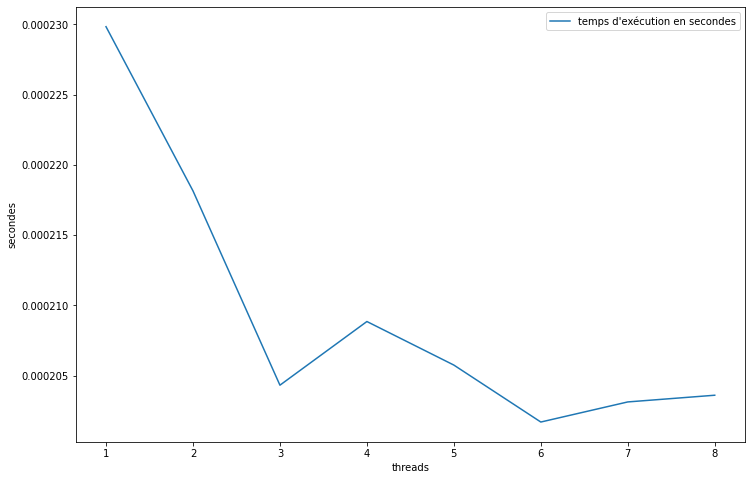

In [12]:
#Initialisation
import pi
n = 300
h = 1.0 / n
threads = 8


temps_execution = []
for i in range(0,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        pyc_pi = epyccel(pi, language='fortran', accelerators=['openmp'])
        import timeit
        t1 = time.time()

        Pi_calc = pyc_pi.pi(n, h)
        temps_execution.append(time.time()- t1)
print(temps_execution) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()


## Exercise 5 Reduction of an array

The given program contained in the `reduction_tab.py` file is extracted from a chemistry code. It reduces a three-dimensional array into a vector. The aim of this exercise is to parallelize this calculation kernel without changing the loop order in the provided code (i.e. k,j,i)

1. Analyse the data-sharing attributes of the variables and adapt the source code so that the K outermost loop is parallelized.
2. Compare the performance obtained by using the thread/core binding default execution on Ada and by using scatter binding. Suggest an explanation for the poor performance of the latter.
3. Optimise the source code for the scatter mode with taking into account the memory affinity. Why does this third series of executions give the best performance 

In [13]:
%%file reduction_tab.py

from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads

omp_set_num_threads(4)

def threads_num():
    from pyccel.stdlib.internal.openmp import  omp_get_thread_num
    return omp_get_thread_num()
def initialize_table(tab:'float[:,:,:]', nmolec:'int', n:'int', nmol:'int'):
    # Initialisation du tableau
    # First-touch pour garantir un fonctionnement optimal sur les systemes NUMA
#$ omp parallel
    #$ omp for collapse(3)
    for k in range(nmolec):
        for j in range(n):
            for i in range(nmol):
                tab[ i,j,k ] = i + j + k
    #$ omp end parallel

def reduction(tab:'float[:,:,:]', tab1:'float[:]', tab2:'float[:]', nmolec:'int', nmol:'int', n:'int'):
    
    #$ omp parallel
    #$ omp for 
    for k in range(nmolec):
        tab1[:nmol] = 0
        for j in range(n):
            for i in range(nmol):
                tab1[i] = tab1[i] + tab[i,j,k]
        tab2[:nmol] = tab2[:nmol] + 2 * tab1[:nmol]
    #$ omp end parallel

Overwriting reduction_tab.py


In [14]:
np.empty((100,10,100), dtype=np.double).shape
omp_set_num_threads(4)

In [18]:
from os import error

if __name__ == '__main__':
    import numpy as np
    import time

    # default dimension
    nmolec = 100
    nmol   = 100
    n      = 10

    tab     = np.empty((nmol, n, nmolec), dtype=np.double)
    tab1    = np.empty((nmol), dtype=np.double)
    tab2    = np.zeros((nmol), dtype=np.double)

    # pyccelize reduction tab module
    from pyccel.epyccel import epyccel
    import reduction_tab

    threads = 8
    omp_set_num_threads(threads)
    
    reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
    
    print("Execution of reduction table in parallele with", threads, "threads")

    # initialize tab 
    reduction.initialize_table(tab, nmol, n, nmolec)

    # start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time

    # -------------------- computing ------------------
    reduction.reduction(tab, tab1, tab2, nmolec, nmol, n)
    # ------------------ End computing ----------------

    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0

    # verification of results
    tab2c = np.zeros((nmol), dtype=np.double)
    for k in range(nmolec):
        tab1c = np.zeros((nmol), dtype=np.double)
        for j in range(n):
            for i in range(nmol):
                tab1c[i] = tab1c[i] + tab[i, j, k]
        tab2c [:] = tab2c[:nmol] + 2 * tab1c[:]
    err = np.max(np.abs(tab2c - tab2) / np.abs(tab2c))
    print(
        "Temps elapsed  :", t_elapsed   , "\n",
        "Temps CPU      :", tcpu        , "\n",
        "Erreur relative:", err         , "\n"
    )

Execution of reduction table in parallele with 8 threads
Temps elapsed  : 0.0001506805419921875 
 Temps CPU      : 0.00015016799999933994 
 Erreur relative: 0.15095 



### Measure the code performance and plot the speedup curves obtained.

[0.0003399848937988281, 0.00014400482177734375, 0.0001399517059326172, 0.00013208389282226562, 0.00013065338134765625, 0.0001347064971923828, 0.00013136863708496094, 0.00013756752014160156]


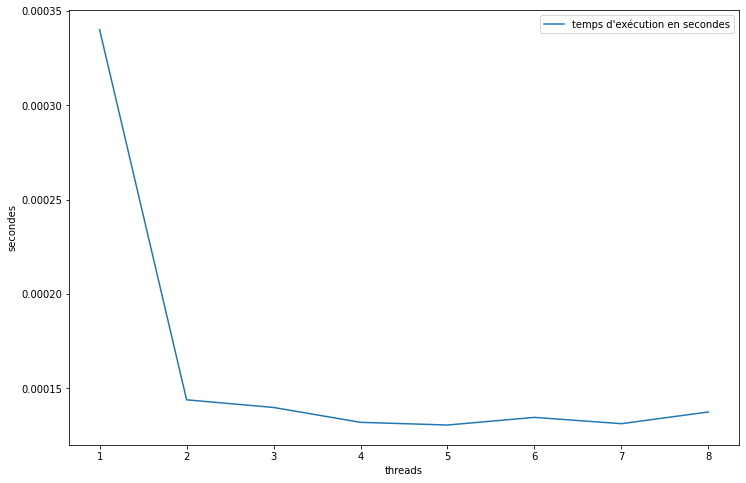

In [19]:
#Initialisation
nmolec = 100
nmol   = 100
n      = 10

tab     = np.empty((nmol, n, nmolec), dtype=np.double)
tab1    = np.empty((nmol), dtype=np.double)
tab2    = np.zeros((nmol), dtype=np.double)



temps_execution = []
for i in range(0,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        reduction = epyccel(reduction_tab, language='fortran', accelerators=['openmp'])
        import timeit
        t1 = time.time()

        reduction.reduction(tab, tab1, tab2, nmolec, nmol, n)
        temps_execution.append(time.time()- t1)
print(temps_execution) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()


# Exercise 6 Matrix product by the Strassen algorithm

Considering the following code that calculates the matrix product :

$$C = A \times B$$

by using Strassen’s recursive algorithm.

In this exercise, you must :
1. Analyse and parallelize the code by using OpenMP tasks.
2. Measure the code performance and plot the speedup curves obtained.

In [20]:
import time, math
import numpy as np

def threads_num():
    #complete your function
    from pyccel.stdlib.internal.openmp import  omp_get_thread_num
    return omp_get_thread_num()

def strassen_multiply(A:'float[:,:]', B:'float[:,:]', C:'float[:,:]', n:'int'):
    import numpy as np
    #$ omp parallel
    if n & 1 != 0  or n < 128:
        C[:,:] = np.matmul(A, B)
    else:
        #$ omp sections 
        #$ omp section
        n2 = n // 2
        A11 = A[ 0:n2, 0:n2 ]
        A21 = A[ n2:n, 0:n2 ]
        A12 = A[ 0:n2, n2:n ]
        A22 = A[ n2:n, n2:n ]
        #$ omp end section
        
        #$ omp section
        B11 = B[ 0:n2, 0:n2 ]
        B21 = B[ n2:n, 0:n2 ]
        B12 = B[ 0:n2, n2:n ]
        B22 = B[ n2:n, n2:n ]
        #$ omp end section
        
        #$ omp section
        Q1 = np.empty((n2, n2), dtype=np.double)
        Q2 = np.empty((n2, n2), dtype=np.double)
        Q3 = np.empty((n2, n2), dtype=np.double)
        Q4 = np.empty((n2, n2), dtype=np.double)
        Q5 = np.empty((n2, n2), dtype=np.double)
        Q6 = np.empty((n2, n2), dtype=np.double)
        Q7 = np.empty((n2, n2), dtype=np.double)
        #$ omp end section
        #$ omp end sections
        
        strassen_multiply(A11+A22, B11+B22, Q1, n2)
        strassen_multiply(A21+A22, B11, Q2, n2)
        strassen_multiply(A11, B12-B22, Q3, n2)
        strassen_multiply(A22, -B11+B21, Q4, n2) 
        strassen_multiply(A11+A12, B22, Q5, n2)
        strassen_multiply(-A11+A21, B11+B12, Q6, n2)
        strassen_multiply(A12-A22, B21+B22, Q7, n2)
        C[:n2,:n2] = Q1+Q4-Q5+Q7
        C[n2:n,:n2] = Q2+Q4
        C[:n2,n2:n] = Q3+Q5
        C[n2:n,n2:n] = Q1+Q3-Q2+Q6
    #$ omp end parallel

In [21]:
def calcul_erreur(n, A, B, C):
    D = np.matmul(A, B) 
    error = 0.0
    #$ omp end parallel
    #$ omp for colapse(2)
    for i in range(n):
        for j in range(n):
            e = C[ i, j ] - D[ i, j ]
            error += e * e

    error = math.sqrt(error) / n
    #$ omp end parallel
    return error

In [22]:

if __name__ == '__main__':
    n = 256
    from pyccel.stdlib.internal.openmp import omp_set_num_threads
    threads=8
    omp_set_num_threads(threads)
    # Initialize Matrices
    np.random.seed(421)
    A = np.random.uniform(0, 1, (n, n))
    B = np.random.uniform(0, 1, (n, n))
    C = np.empty((n,n), dtype=np.double)

    
    from pyccel.epyccel import epyccel
    strassen = epyccel(strassen_multiply, accelerators=['openmp'])
#    num_threads = epyccel(threads_num, accelerators=['openmp'])
    print("Execution of Strassen in parallele with", threads, "threads")
    
    
    # Start timing
    tcpu_0 = time.process_time() # CPU time
    t_elapsed_0 = time.time()    # Wall time
    # -------------------- computing ------------------
    # Calcul C=A*B par la methode recursive de Strassen
    strassen(A, B, C, n)
    # ------------------ end computing ----------------
    # CPU time spent
    tcpu_1 = time.process_time()
    tcpu = tcpu_1 - tcpu_0

    # Wall time spent
    t_elapsed_1 = time.time()
    t_elapsed = t_elapsed_1 - t_elapsed_0
    # Print result
    print(
      "   Erreur        :", calcul_erreur(n, A, B, C),  "\n",
	  "   Temps elapsed :", t_elapsed,                  "\n",
	  "   Temps CPU     :", tcpu,                       "\n",
    )


Execution of Strassen in parallele with 8 threads
   Erreur        : 3.377379142794413e-14 
    Temps elapsed : 0.008322477340698242 
    Temps CPU     : 0.02412497599999952 



### Measure the code performance and plot the speedup curves obtained.

[0.006045341491699219, 0.012398004531860352, 0.009245157241821289, 0.005866050720214844, 0.005882978439331055, 0.006180763244628906, 0.00599980354309082, 0.00588226318359375]


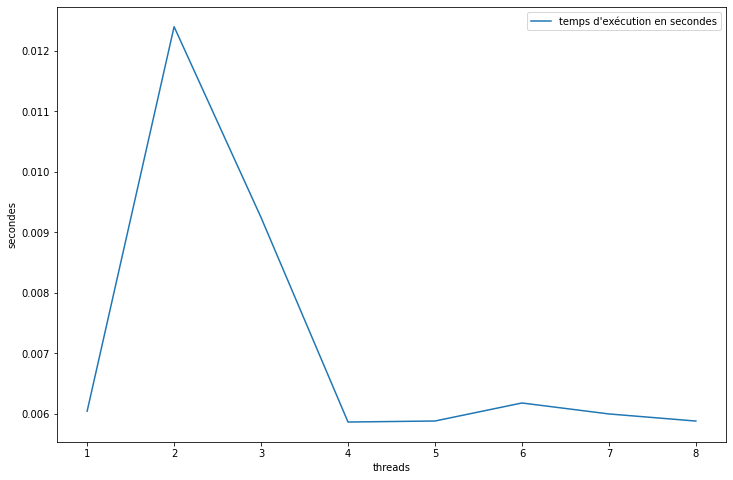

In [25]:
#Initialisation
n = 256
from pyccel.stdlib.internal.openmp import omp_set_num_threads
threads=8
omp_set_num_threads(threads)
# Initialize Matrices
np.random.seed(421)
A = np.random.uniform(0, 1, (n, n))
B = np.random.uniform(0, 1, (n, n))
C = np.empty((n,n), dtype=np.double)



temps_execution = []
for i in range(0,threads):
    if __name__ == '__main__':
        from pyccel.epyccel import epyccel
        from pyccel.stdlib.internal.openmp import omp_get_num_threads, omp_get_thread_num, omp_in_parallel, omp_set_num_threads
        omp_set_num_threads(i)
        strassen = epyccel(strassen_multiply, accelerators=['openmp'])
        import timeit
        t1 = time.time()

        strassen(A, B, C, n)
        temps_execution.append(time.time()- t1)
print(temps_execution) 

import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
threads = np.arange(1,9,1)
plt.plot(threads,temps_execution, label='temps d\'exécution en secondes')
plt.xlabel("threads")
plt.ylabel("secondes")
plt.legend()
plt.show()
